In [1]:
!pip install wordcloud
!pip install textblob
!pip install keras
!pip install keras-preprocessing
!pip install -q pycaret
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install transformers
!pip install torch
!pip install nltk

ERROR: Cannot uninstall matplotlib 3.10.0, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps matplotlib==3.10.0'.


Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV


from keras.layers import Bidirectional, LSTM, Dropout, Dense, Embedding, Input
from keras.models import Model

import os
from keras.layers import Input


import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the Fake.csv file
df_fake = pd.read_csv(r'C:\Users\dmade\Downloads\archive (5)/Fake.csv')
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
# Load the True.csv file
df_true = pd.read_csv(r'C:\Users\dmade\Downloads\archive (5)/True.csv')
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
# Analyze the distribution of labels in Fake.csv
df_fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

In [6]:
# Analyze the distribution of labels in True.csv
df_true['subject'].value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

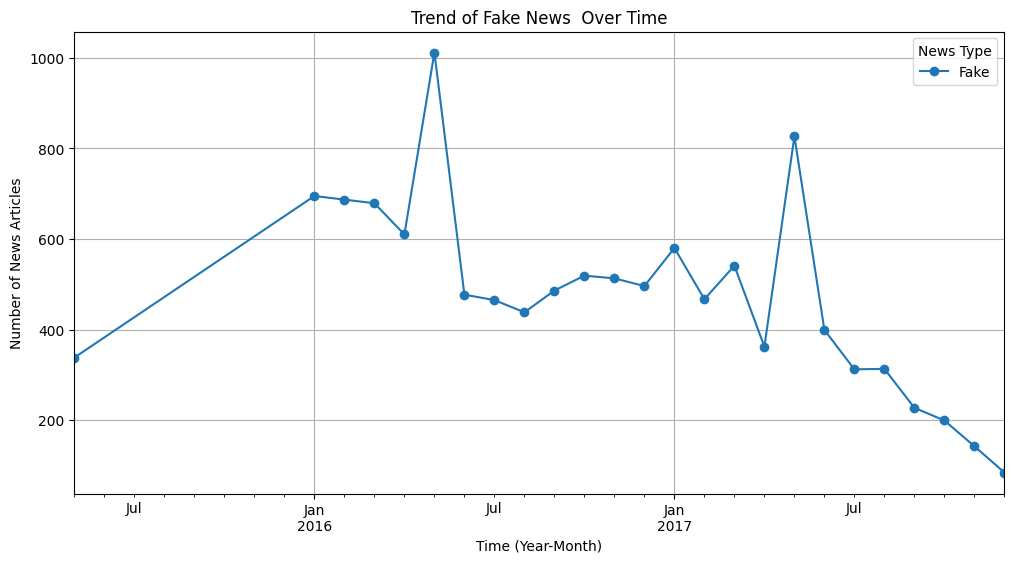

In [7]:

# Combine the datasets for unified analysis
df_fake['label'] = 'Fake'
df_true['label'] = 'True'
data_df = pd.concat([df_fake, df_true], ignore_index=True)
# Ensure the 'date' column is in datetime format
data_df['date'] = pd.to_datetime(data_df['date'], errors='coerce')

# Group data by year-month and label (Fake/True)
data_df['year_month'] = data_df['date'].dt.to_period('M')
news_trend = data_df.groupby(['year_month', 'label']).size().unstack()

# Plot the trend
news_trend.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Trend of Fake News  Over Time')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Number of News Articles')
plt.legend(title='News Type')
plt.grid()
plt.show()


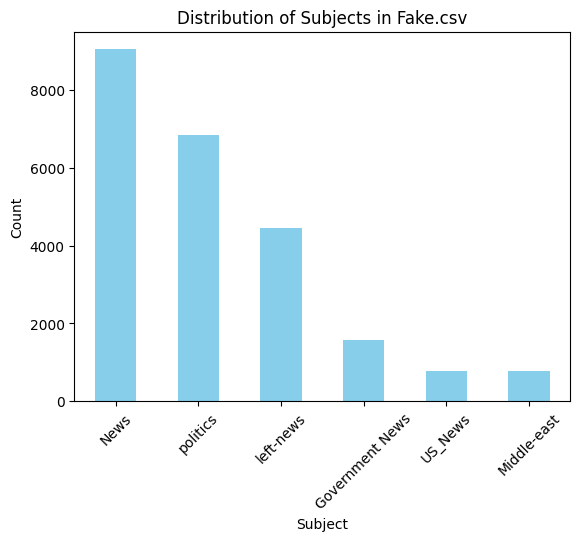

In [8]:
# Plot distribution of subjects in Fake.csv
df_fake['subject'].value_counts().plot(kind='bar', color='skyblue', title='Distribution of Subjects in Fake.csv')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

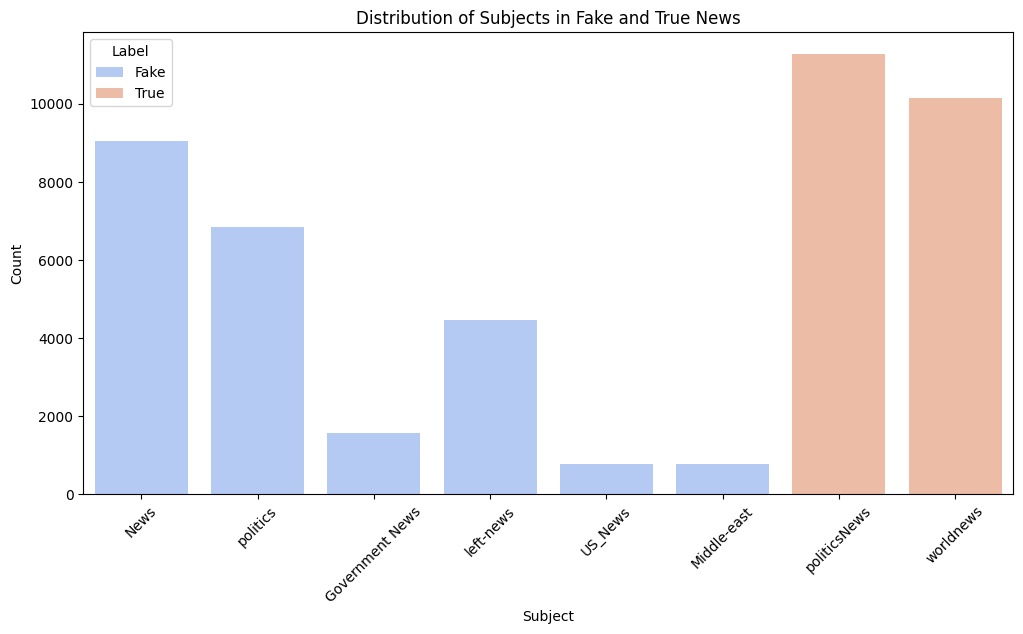

In [9]:
# Add a new column to each dataframe to indicate if the news is fake or true
df_fake['label'] = 'Fake'
df_true['label'] = 'True'

# Combine the dataframes
df_combined = pd.concat([df_fake, df_true], ignore_index=True)

# Plot the distribution of subjects for both fake and true news
plt.figure(figsize=(12, 6))
sns.countplot(data=df_combined, x='subject', hue='label', palette='coolwarm')
plt.title('Distribution of Subjects in Fake and True News')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Label')
plt.show()

In [10]:
# Check for missing values in df_fake
df_fake.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [11]:
# Check for missing values in df_true
df_true.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

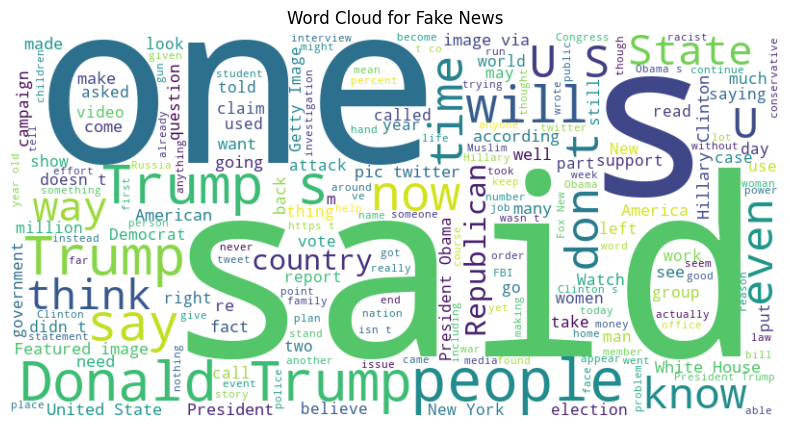

In [12]:
# Generate word cloud for fake news
fake_text = ' '.join(df_fake['text'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fake News')
plt.show()

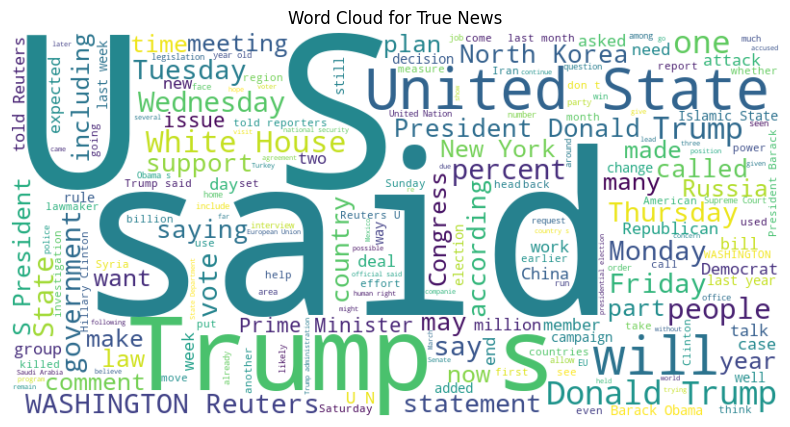

In [13]:
# Generate word cloud for true news
true_text = ' '.join(df_true['text'])
wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for True News')
plt.show()

In [14]:


# Add labels
df_fake['label'] = 0  # 0 for fake news
df_true['label'] = 1  # 1 for true news

# Combine datasets
df = pd.concat([df_fake, df_true], axis=0)
df.drop(['subject', 'date'], axis=1, inplace=True)
df.head(10)

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,0


In [15]:
# Combine title and text columns into a single column
df['combined_text'] = df['title'] + ' ' + df['text']

# Drop the original title and text columns
df = df[['combined_text', 'label']]

# Display the first few rows
df

,combined_text,label
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,1
21413,LexisNexis withdrew two products from Chinese ...,1
21414,Minsk cultural hub becomes haven from authorit...,1
21415,Vatican upbeat on possibility of Pope Francis ...,1


In [16]:
# Download and verify necessary NLTK resources

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean text
def preprocess_text(text):
    # Convert to string in case input is not string
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stop words and lemmatize
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    
    # Join tokens back into text
    return ' '.join(cleaned)

# Apply preprocessing to combined_text
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Remove duplicates based on the processed text
df = df.drop_duplicates(subset='processed_text').reset_index(drop=True)

# Print sample of cleaned text
print("Sample of original vs cleaned text:")
for i in range(3):
    print("\nOriginal:", df['combined_text'].iloc[i][:100], "...")
    print("Cleaned:", df['processed_text'].iloc[i][:100], "...")

# Print shape of dataframe
print("\nShape of cleaned dataframe:", df.shape)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dmade\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dmade\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Sample of original vs cleaned text:

Original:  Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just co ...
Cleaned: donald trump sends embarrassing new year eve message disturbing donald trump wish american happy new ...

Original:  Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee C ...
Cleaned: drunk bragging trump staffer started russian collusion investigation house intelligence committee ch ...

Original:  Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’ On Friday ...
Cleaned: sheriff david clarke becomes internet joke threatening poke people eye friday revealed former milwau ...

Shape of cleaned dataframe: (38968, 3)


In [17]:
# Check for duplicates in the original DataFrame
duplicate_count = df.duplicated(subset='processed_text').sum()
print(f"Number of duplicates in the original DataFrame: {duplicate_count}")

Number of duplicates in the original DataFrame: 0


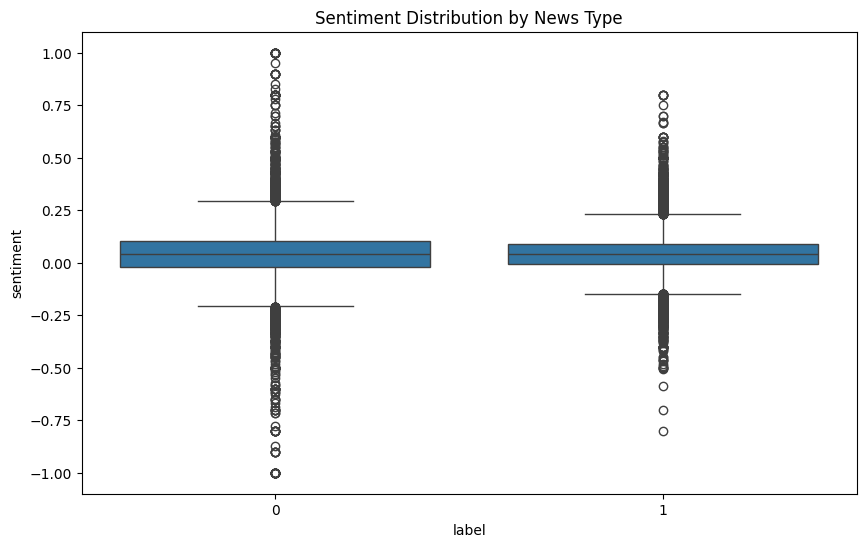

In [18]:
# Sentiment analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['sentiment'] = df['processed_text'].apply(get_sentiment)

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='sentiment', data=df)
plt.title('Sentiment Distribution by News Type')
plt.show()

In [19]:
# Print class distribution first
print("Class Distribution:")
print(df['label'].value_counts())
print("\n")

# Create feature and target variables
X_transcription = df['processed_text']
y_transcription = df['label']

# Display the shapes of X and y to confirm
print("Shape of X (features):", X_transcription.shape)
print("Shape of y (labels):", y_transcription.shape)


Class Distribution:
label
1    21067
0    17901
Name: count, dtype: int64


Shape of X (features): (38968,)
Shape of y (labels): (38968,)



Text length statistics:
count    38968.000000
mean      1721.573522
std       1340.188029
min          0.000000
25%        932.000000
50%       1556.000000
75%       2148.000000
max      37849.000000
Name: text_length, dtype: float64


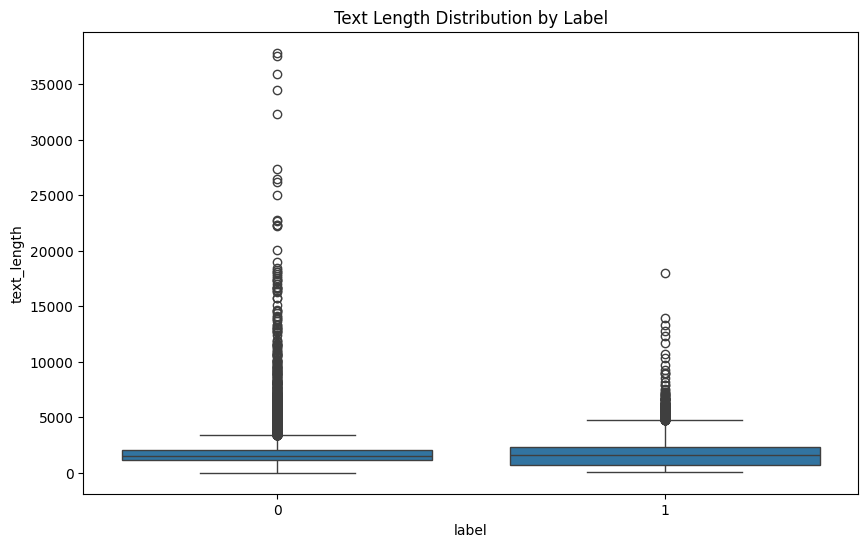

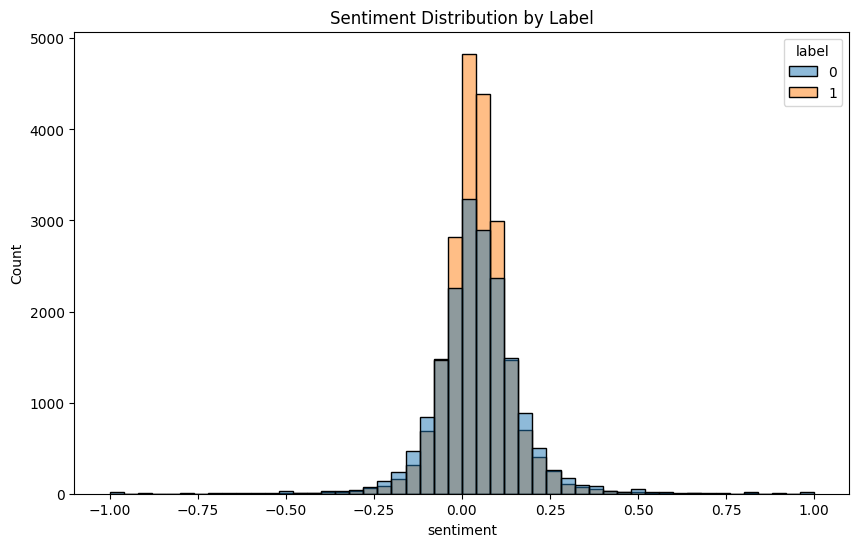

In [20]:


# Check text length statistics
df['text_length'] = df['processed_text'].str.len()
print("\nText length statistics:")
print(df['text_length'].describe())

# Check for any extreme values or potential outliers in text length
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Text Length Distribution by Label')
plt.show()

# Check for extreme sentiment values
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='sentiment', hue='label', bins=50)
plt.title('Sentiment Distribution by Label')
plt.show()

1. Class Balance:
- The dataset is relatively balanced with 54.5% true news (20,921 samples) and 45.5% fake news (17,445 samples)
- This slight imbalance is not severe enough to require resampling techniques

2. Text Length:
- Mean text length is 1,766 characters with high variance (std: 1,342)
- There are some extreme outliers with max length of 38,049 characters
- True news tends to have slightly longer texts on average
  
  3. Sentiment Distribution:
- Both classes show a range of sentiment values
- Fake news shows slightly more extreme sentiment values (both positive and negative)
- True news tends to be more neutral in sentiment

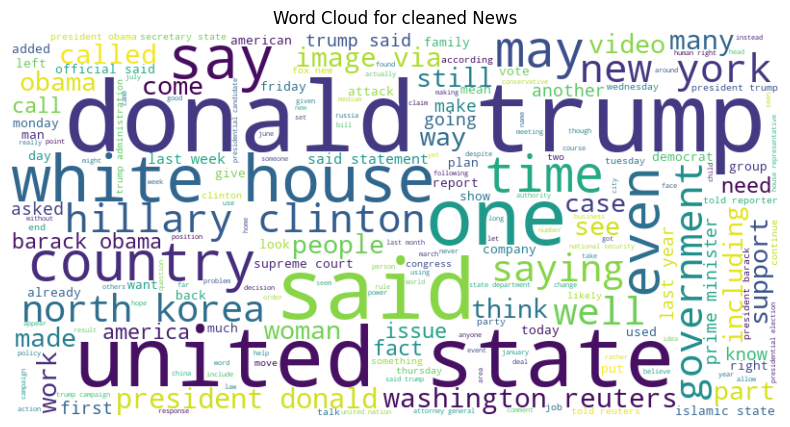

In [22]:
# Generate word cloud for  news
true_text = ' '.join(df['processed_text'])
wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for cleaned News')
plt.show()

In [23]:
# Calculated Metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


def calculate_metrics(y_true_list, y_pred_list):
    """
    Calculate evaluation metrics including Accuracy, Precision, Recall, F1 Score, ROC AUC) across multiple samples.

    Parameters:
    y_true_list : list of array-like of shape (n_samples,)
        List of true binary labels.
    y_pred_list : list of array-like of shape (n_samples,)
        List of predicted binary labels.

    Returns:
    dict
        A dictionary containing the calculated metrics.
    """
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    

    for y_true, y_pred in zip(y_true_list, y_pred_list):
        # Accuracy
        accuracy_scores.append(accuracy_score(y_true, y_pred))

        # Precision
        precision_scores.append(precision_score(y_true, y_pred))

        # Recall
        recall_scores.append(recall_score(y_true, y_pred))

        # F1 Score
        f1_scores.append(f1_score(y_true, y_pred))

        # ROC Curve and AUC
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)

        

    return {
        'Mean Accuracy': round(np.mean(accuracy_scores), 3),
        'Mean Precision': round(np.mean(precision_scores), 3),
        'Mean Recall': round(np.mean(recall_scores), 3),
        'Mean F1 Score': round(np.mean(f1_scores), 3),
        'Mean ROC AUC': np.mean(roc_auc_scores),
        'y_pred': y_pred_list,  # List of all predicted labels
        'roc_curve': [fpr, tpr, thresholds],  # ROC curve data
        'auc': roc_auc_scores  # AUC for each sample
    }

In [24]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    """
    Plots a confusion matrix.

    Parameters:
        y_true: array-like
            The true target labels.
        y_pred: array-like
            The predicted target labels.
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Define label names
    labels = ['False', 'True']
    
    # Plot confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [25]:
# Loss Accuracy Plot

def plot_loss_and_accuracy(history, scale=10):
    """
    Plot loss and accuracy curves.

    Parameters:
    history : keras.callbacks.History
        History object returned by model.fit().

    Returns:
    None
    """
    # Extract loss and accuracy values from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(0, len(history.history['loss']), scale), fontsize=10)
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(range(0, len(history.history['loss']), scale), fontsize=10)
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [26]:
# Assuming 'label' is the column in your original DataFrame that contains the target labels
X_transcription = df['processed_text']
y_transcription = df['label']

# Display the shapes of X and y to confirm
print("Shape of X (features):", X_transcription.shape)
print("Shape of y (labels):", y_transcription.shape)

Shape of X (features): (38968,)
Shape of y (labels): (38968,)


<a id="Streamlining Data flow"></a>
<h1 style="background-image: url(https://i.postimg.cc/90vFxNXg/Screenshot-2025-02-28-232028.png); font-family: tahoma; font-size: 120%; color: white; text-align: center; border-radius: 15px 50px; padding: 7px; border: solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">
  <b>Step 1 | BERT </b>
</h1>

In [28]:
# Initial split: 80% train and 20% temporary (to split into validation and test later)
train_text, temp_text, train_labels, temp_labels = train_test_split(
    X_transcription,
    y_transcription,
    test_size=0.2,  # 20% for validation and test combined
    random_state=42,
    stratify=y_transcription
)

# Further split the temporary set into validation and test sets evenly
test_text, val_text, test_labels, val_labels = train_test_split(
    temp_text, 
    temp_labels,
    test_size=0.5,  # Split the remaining 20% equally into 10% validation and 10% test
    random_state=42,
    stratify=temp_labels  # Ensure class balance is preserved
)

# Optional: Check for overlaps to ensure data leaks are not possible
train_set = set(map(tuple, train_text.to_numpy()))
val_set = set(map(tuple, val_text.to_numpy()))
test_set = set(map(tuple, test_text.to_numpy()))

print(f"Train-Val Overlap: {len(train_set & val_set)}")  # Overlap should be 0
print(f"Train-Test Overlap: {len(train_set & test_set)}")  # Overlap should be 0
print(f"Val-Test Overlap: {len(val_set & test_set)}")  # Overlap should be 0

# Print shapes using correct variable names
print("Shape of train_text:", train_text.shape)
print("Shape of val_text:", val_text.shape)
print("Shape of test_text:", test_text.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of val_labels:", val_labels.shape)
print("Shape of test_labels:", test_labels.shape)


Train-Val Overlap: 0
Train-Test Overlap: 0
Val-Test Overlap: 0
Shape of train_text: (31174,)
Shape of val_text: (3897,)
Shape of test_text: (3897,)
Shape of train_labels: (31174,)
Shape of val_labels: (3897,)
Shape of test_labels: (3897,)


In [29]:
import torch
from transformers import AutoModel, BertTokenizerFast

# Load BERT model and tokenizer
bert_model = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')



In [30]:
# BERT tokenizer functionality
sample_data = ['Build fake news model.',
               'Using bert.']
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data, padding=True)
print(tokenized_sample_data)

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [31]:
# Set a reasonable max length for BERT (common practice is 512 or less)
MAX_LENGTH = 128

print("Using max length:", MAX_LENGTH)

# tokenize and encode sequence in train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',  # Updated from pad_to_max_length which is deprecated
    truncation=True,
    return_tensors='pt'  # Return PyTorch tensors
)

# tokenize and encode sequence in validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# tokenize and encode sequence in test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

Using max length: 128


In [32]:
import torch
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels_num = le.fit_transform(train_labels)
val_labels_num = le.transform(val_labels)
test_labels_num = le.transform(val_labels)

# convert integers to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels_num.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels_num.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels_num.tolist())




In [33]:
# Data loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 16

# Ensure labels are integers
train_labels = train_labels.astype(int)
temp_labels = temp_labels.astype(int)
test_labels = test_labels.astype(int)
val_labels = val_labels.astype(int)

# The tokenized inputs are already PyTorch tensors, so we can use them directly
train_seq = tokens_train['input_ids']
train_mask = tokens_train['attention_mask']
train_y = torch.tensor(train_labels.tolist(), dtype=torch.long)

val_seq = tokens_val['input_ids'] 
val_mask = tokens_val['attention_mask']
val_y = torch.tensor(val_labels.tolist(), dtype=torch.long)

test_seq = tokens_test['input_ids']
test_mask = tokens_test['attention_mask']
test_y = torch.tensor(test_labels.tolist(), dtype=torch.long)



# Create TensorDatasets
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)



In [34]:
import torch.nn as nn 
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW

# Define device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define model architecture
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, sent_id, mask):
        cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

model = BERT_Arch(bert_model)


from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 1e-5)

# define loss function
cross_entropy = nn.NLLLoss()

epochs = 5

Using device: cuda


In [35]:
# define train and evaluation functions
def train():
    model.train()
    total_loss, total_accuracy = 0, 0

    for step,batch in enumerate(train_dataloader):
        if step % 150 == 0 and not step == 0:
            print(' batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))
        batch = [r for r in batch]
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss = total_loss + loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds=preds.detach().cpu().numpy()

    avg_loss = total_loss / len(train_dataloader)

    return avg_loss

def evaluate():
    print("\n evaluating ...")
    model.eval()
    total_loss, total_accuracy = 0, 0
    for step,batch in enumerate(val_dataloader):
        if step % 150 == 0 and not step == 0:
            print(' batch {:>5,} of {:>5,}.'.format(step, len(val_dataloader)))
        batch = [t for t in batch]
        sent_id, mask, labels = batch
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss
            preds = preds.detach().cpu().numpy()
    avg_loss = total_loss / len(val_dataloader)
    return avg_loss

In [36]:
# Train model and predict
best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    valid_loss = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

print(f'\n training loss: {train_loss:.3f}')
print(f'\n validation loss: {valid_loss:.3f}')

   
# Calculate training and validation accuracy after each epoch
def calculate_accuracy(data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in data_loader:
            sent_id, mask, labels = batch
            preds = model(sent_id, mask)
            preds = torch.argmax(preds, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

train_accuracy = calculate_accuracy(train_dataloader)
val_accuracy = calculate_accuracy(val_dataloader)
print(f'\n Training Accuracy: {train_accuracy * 100:.4f}%')
print(f'\n Validation Accuracy: {val_accuracy * 100:.4f}%')



 Epoch 1 / 5
 batch   150 of 1,949.
 batch   300 of 1,949.
 batch   450 of 1,949.
 batch   600 of 1,949.
 batch   750 of 1,949.
 batch   900 of 1,949.
 batch 1,050 of 1,949.
 batch 1,200 of 1,949.
 batch 1,350 of 1,949.
 batch 1,500 of 1,949.
 batch 1,650 of 1,949.
 batch 1,800 of 1,949.

 evaluating ...
 batch   150 of   244.

 Epoch 2 / 5
 batch   150 of 1,949.
 batch   300 of 1,949.
 batch   450 of 1,949.
 batch   600 of 1,949.
 batch   750 of 1,949.
 batch   900 of 1,949.
 batch 1,050 of 1,949.
 batch 1,200 of 1,949.
 batch 1,350 of 1,949.
 batch 1,500 of 1,949.
 batch 1,650 of 1,949.
 batch 1,800 of 1,949.

 evaluating ...
 batch   150 of   244.

 Epoch 3 / 5
 batch   150 of 1,949.
 batch   300 of 1,949.
 batch   450 of 1,949.
 batch   600 of 1,949.
 batch   750 of 1,949.
 batch   900 of 1,949.
 batch 1,050 of 1,949.
 batch 1,200 of 1,949.
 batch 1,350 of 1,949.
 batch 1,500 of 1,949.
 batch 1,650 of 1,949.
 batch 1,800 of 1,949.

 evaluating ...
 batch   150 of   244.

 Epoch 4 

In [37]:
# Ensure test labels are correctly encoded
test_labels_num = le.transform(test_labels)  # Fix the duplicate val_labels issue

# Convert to PyTorch tensors
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels_num.tolist(), dtype=torch.long)

# Create TensorDataset and DataLoader for testing
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Define test accuracy function
def test_accuracy(data_loader):
    model.eval()  # Set model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():
        for batch in data_loader:
            sent_id, mask, labels = batch
            preds = model(sent_id, mask)
            preds = torch.argmax(preds, dim=1)  # Get predicted class
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

# Compute and print test accuracy
test_acc = test_accuracy(test_dataloader)
print(f'\n ✅ Best Test Accuracy: {test_acc * 100:.4f}%')



 ✅ Best Test Accuracy: 99.9743%


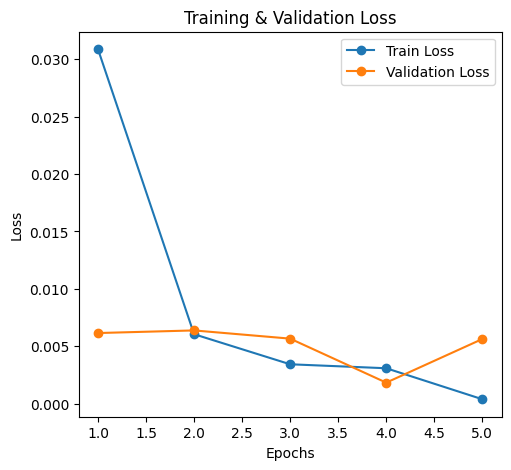

In [38]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()



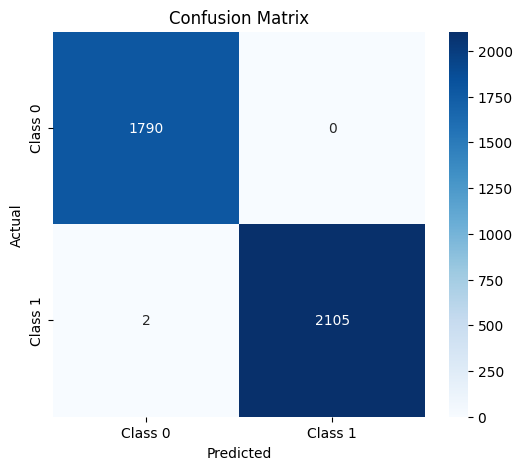


Classification Report:
               precision    recall  f1-score   support

           0      0.999     1.000     0.999      1790
           1      1.000     0.999     1.000      2107

    accuracy                          0.999      3897
   macro avg      0.999     1.000     0.999      3897
weighted avg      0.999     0.999     0.999      3897



In [49]:
# Compute Predictions and Confusion Matrix
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_dataloader:
        sent_id, mask, labels = batch
        preds = model(sent_id, mask)
        preds = torch.argmax(preds, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n", classification_report(all_labels, all_preds, digits=3))

<a id="Streamlining Data flow"></a>
<h1 style="background-image: url(https://i.postimg.cc/90vFxNXg/Screenshot-2025-02-28-232028.png); font-family: tahoma; font-size: 120%; color: white; text-align: center; border-radius: 15px 50px; padding: 7px; border: solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">
  <b>Step 2
    | Minilm </b>
</h1>

In [52]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. DATA SPLIT (80-10-10) ---
X_train_minilm, X_temp, y_train_minilm, y_temp = train_test_split(
    X_transcription, y_transcription,
    test_size=0.2, random_state=42, stratify=y_transcription
)

X_val_minilm, X_test_minilm, y_val_minilm, y_test_minilm = train_test_split(
    X_temp, y_temp,
    test_size=0.5, random_state=42, stratify=y_temp
)

# Print sizes for verification
print("Features:")
print("Train set size:", X_train_minilm.shape[0])
print("Validation set size:", X_val_minilm.shape[0])
print("Test set size:", X_test_minilm.shape[0])

print("\nLabels:")
print("Train set size:", y_train_minilm.shape[0])
print("Validation set size:", y_val_minilm.shape[0])
print("Test set size:", y_test_minilm.shape[0])


Using device: cuda
Features:
Train set size: 31174
Validation set size: 3897
Test set size: 3897

Labels:
Train set size: 31174
Validation set size: 3897
Test set size: 3897


In [54]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# --- 2. TOKENIZATION ---
model_name = "microsoft/MiniLM-L12-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [str(text) for text in texts]
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = int(self.labels.iloc[idx]) if hasattr(self.labels, 'iloc') else int(self.labels[idx])
        encoding = tokenizer(text, truncation=True, padding='max_length', max_length=461, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label)
        }

# Load datasets
train_dataset = NewsDataset(X_train_minilm, y_train_minilm)
val_dataset = NewsDataset(X_val_minilm, y_val_minilm)
test_dataset = NewsDataset(X_test_minilm, y_test_minilm)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# --- 3. MODEL ---
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 10
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
import torch
from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm

# --- 3. MODEL ---
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 10
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# --- 4. TRAINING WITH EARLY STOPPING ---
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # --- Validation ---
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)

    print(f"\nEpoch {epoch+1} Results:")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # --- Early Stopping ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_minilm_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# --- 5. EVALUATION ON TEST SET ---
print("\nLoading best model...")
model.load_state_dict(torch.load("best_minilm_model.pt"))
model.eval()

correct_test = 0
total_test = 0
y_true_minilm = []
y_pred_minilm = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

        y_true_minilm.extend(labels.cpu().numpy())
        y_pred_minilm.extend(preds.cpu().numpy())

test_accuracy = correct_test / total_test
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Fake", "Real"], digits=3))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 1949/1949 [31:57<00:00,  1.02it/s]  



Epoch 1 Results:
Train Loss: 0.0539 | Train Acc: 0.9835
Val Loss: 0.0075 | Val Acc: 0.9972


Epoch 2/10: 100%|██████████| 1949/1949 [32:25<00:00,  1.00it/s]



Epoch 2 Results:
Train Loss: 0.0051 | Train Acc: 0.9988
Val Loss: 0.0014 | Val Acc: 0.9995


Epoch 3/10: 100%|██████████| 1949/1949 [32:26<00:00,  1.00it/s]



Epoch 3 Results:
Train Loss: 0.0034 | Train Acc: 0.9992
Val Loss: 0.0007 | Val Acc: 0.9997


Epoch 4/10: 100%|██████████| 1949/1949 [32:27<00:00,  1.00it/s]



Epoch 4 Results:
Train Loss: 0.0027 | Train Acc: 0.9994
Val Loss: 0.0040 | Val Acc: 0.9995


Epoch 5/10: 100%|██████████| 1949/1949 [32:26<00:00,  1.00it/s]



Epoch 5 Results:
Train Loss: 0.0025 | Train Acc: 0.9995
Val Loss: 0.0003 | Val Acc: 1.0000


Epoch 6/10: 100%|██████████| 1949/1949 [32:28<00:00,  1.00it/s]



Epoch 6 Results:
Train Loss: 0.0010 | Train Acc: 0.9998
Val Loss: 0.0017 | Val Acc: 0.9992


Epoch 7/10: 100%|██████████| 1949/1949 [32:50<00:00,  1.01s/it]



Epoch 7 Results:
Train Loss: 0.0015 | Train Acc: 0.9996
Val Loss: 0.0022 | Val Acc: 0.9997


Epoch 8/10: 100%|██████████| 1949/1949 [46:54<00:00,  1.44s/it] 



Epoch 8 Results:
Train Loss: 0.0011 | Train Acc: 0.9999
Val Loss: 0.0001 | Val Acc: 1.0000


Epoch 9/10: 100%|██████████| 1949/1949 [32:28<00:00,  1.00it/s]



Epoch 9 Results:
Train Loss: 0.0004 | Train Acc: 1.0000
Val Loss: 0.0000 | Val Acc: 1.0000


Epoch 10/10: 100%|██████████| 1949/1949 [32:26<00:00,  1.00it/s]



Epoch 10 Results:
Train Loss: 0.0029 | Train Acc: 0.9995
Val Loss: 0.0001 | Val Acc: 1.0000

Loading best model...


Testing: 100%|██████████| 244/244 [01:22<00:00,  2.96it/s]



✅ Test Accuracy: 0.9995


NameError: name 'y_true' is not defined

In [58]:
print("\nClassification Report:\n", classification_report(y_true_minilm, y_pred_minilm, target_names=["Fake", "Real"], digits=3))


Classification Report:
               precision    recall  f1-score   support

        Fake      0.999     0.999     0.999      1790
        Real      1.000     1.000     1.000      2107

    accuracy                          0.999      3897
   macro avg      0.999     0.999     0.999      3897
weighted avg      0.999     0.999     0.999      3897



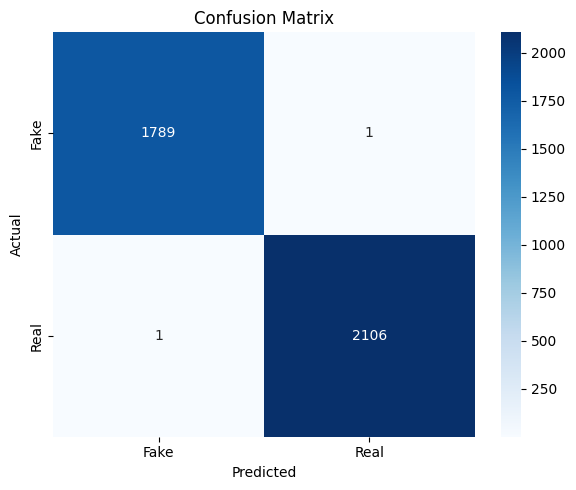

In [60]:
# --- CONFUSION MATRIX ---
def plot_confusion_matrix(y_true_minilm, y_pred_minilm, labels=["Fake", "Real"]):
    cm = confusion_matrix(y_true_minilm, y_pred_minilm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true_minilm, y_pred_minilm)

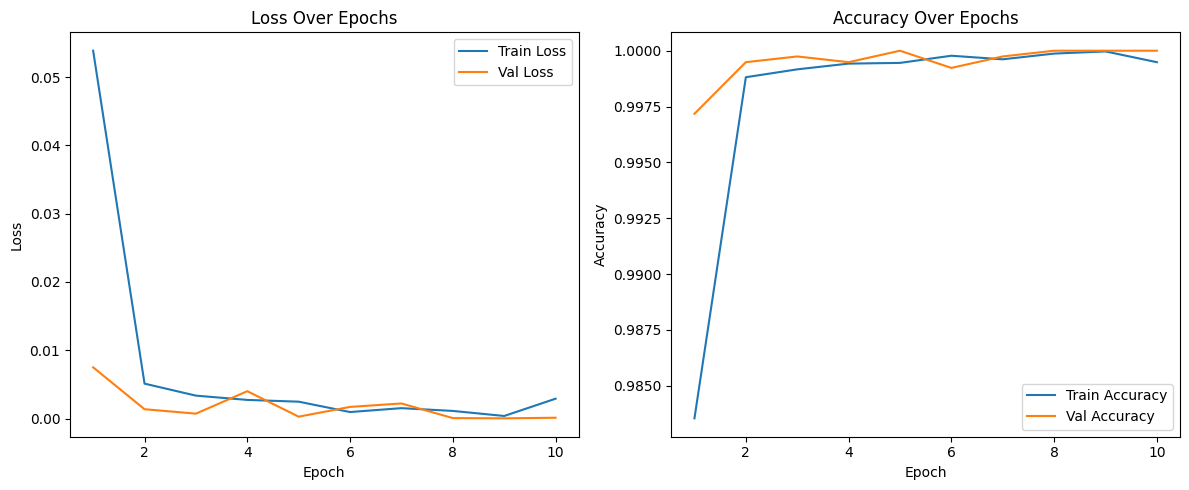

In [62]:
 #--- 6. VISUALIZATION ---
def plot_training(history):
    epochs_range = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['accuracy'], label='Train Accuracy')
    plt.plot(epochs_range, history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)

<a id="Streamlining Data flow"></a>
<h1 style="background-image: url(https://i.postimg.cc/90vFxNXg/Screenshot-2025-02-28-232028.png); font-family: tahoma; font-size: 120%; color: white; text-align: center; border-radius: 15px 50px; padding: 7px; border: solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">
  <b>Step 3 | LSTM</b>
</h1>

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

# Tokenizer parameters
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(X_transcription)
X_seq = tokenizer.texts_to_sequences(X_transcription)

# Determine padding length
avg_len = int(np.mean([len(s.split()) for s in X_transcription]) * 2)
X_pad = pad_sequences(X_seq, maxlen=avg_len)

# Stratified 80-10-10 split
X_train_lstm, X_temp, y_train_lstm, y_temp = train_test_split(X_pad, y_transcription, test_size=0.2, random_state=42, stratify=y_transcription)
X_val_lstm, X_test_lstm, y_val_lstm, y_test_lstm = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Print the sizes of each set
print("Features:")
print("Train set size:", X_train_lstm.shape)
print("Validation set size:", X_val_lstm.shape)
print("Test set size:", X_test_lstm.shape)
print("")
print("Label:")
print("Train set size:", y_train_lstm.shape)
print("Validation set size:", y_val_lstm.shape)
print("Test set size:", y_test_lstm.shape)

Features:
Train set size: (31174, 461)
Validation set size: (3897, 461)
Test set size: (3897, 461)

Label:
Train set size: (31174,)
Validation set size: (3897,)
Test set size: (3897,)


In [70]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_lstm)
y_val = label_encoder.transform(y_val_lstm)
y_test = label_encoder.transform(y_test_lstm)

# Define LSTM model
inputs = Input(shape=(X_train_lstm.shape[1],))
x = Embedding(input_dim=max_words, output_dim=128, input_length=X_train_lstm.shape[1])(inputs)
x = LSTM(64, return_sequences=True, dropout=0.2)(x)
x = LSTM(64, return_sequences=True, dropout=0.2)(x)
x = Dropout(0.3)(x)
x = LSTM(64)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Training
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_lstm, y_val_lstm),
    callbacks=[early_stop, checkpoint],
    shuffle=True
)

# Load best model
model.load_weights('best_lstm_model.h5')

# Test evaluation
loss, accuracy = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"\n✅ Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 461)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 461, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 461, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 461, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 461, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,395,521 (5.32 MB)

 Trainable params: 1,395,521 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
975/975 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9179 - loss: 0.1873
Epoch 1: val_loss improved from inf to 0.04383, saving model to best_lstm_model.h5


975/975 ━━━━━━━━━━━━━━━━━━━━ 377s 377ms/step - accuracy: 0.9179 - loss: 0.1872 - val_accuracy: 0.9838 - val_loss: 0.0438
Epoch 2/15
975/975 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9868 - loss: 0.0396
Epoch 2: val_loss improved from 0.04383 to 0.03616, saving model to best_lstm_model.h5


975/975 ━━━━━━━━━━━━━━━━━━━━ 370s 379ms/step - accuracy: 0.9868 - loss: 0.0396 - val_accuracy: 0.9887 - val_loss: 0.0362
Epoch 3/15
975/975 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.9938 - loss: 0.0228
Epoch 3: val_loss improved from 0.03616 to 0.01923, saving model to best_lstm_model.h5


975/975 ━━━━━━━━━━━━━━━━━━━━ 652s 669ms/step - accuracy: 0.9938 - loss: 0.0228 - val_accuracy: 0.9946 - val_loss: 0.0192
Epoch 4/15
975/975 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9941 - loss: 0.0191
Epoch 4: val_loss did not improve from 0.01923
975/975 ━━━━━━━━━━━━━━━━━━━━ 464s 476ms/step - accuracy: 0.9941 - loss: 0.0191 - val_accuracy: 0.9910 - val_loss: 0.0384
Epoch 5/15
975/975 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9966 - loss: 0.0136
Epoch 5: val_loss did not improve from 0.01923
975/975 ━━━━━━━━━━━━━━━━━━━━ 469s 481ms/step - accuracy: 0.9966 - loss: 0.0136 - val_accuracy: 0.9861 - val_loss: 0.0502
Epoch 6/15
975/975 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9932 - loss: 0.0205
Epoch 6: val_loss did not improve from 0.01923
975/975 ━━━━━━━━━━━━━━━━━━━━ 465s 477ms/step - accuracy: 0.9932 - loss: 0.0205 - val_accuracy: 0.9887 - val_loss: 0.0333
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.

✅ Test Loss: 0.0183
✅ Test 

In [73]:
# Predictions
y_pred_lstm = (model.predict(X_test_lstm) > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_lstm, y_pred_lstm, target_names=['Fake', 'Real'], digits=3))

122/122 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step

Classification Report:
              precision    recall  f1-score   support

        Fake      0.998     0.990     0.994      1790
        Real      0.992     0.998     0.995      2107

    accuracy                          0.994      3897
   macro avg      0.995     0.994     0.994      3897
weighted avg      0.994     0.994     0.994      3897



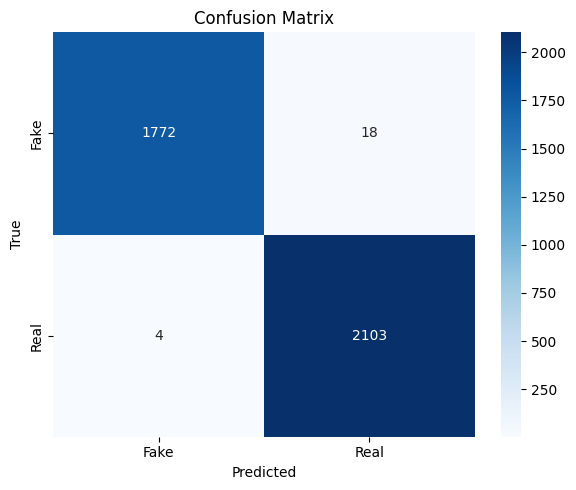

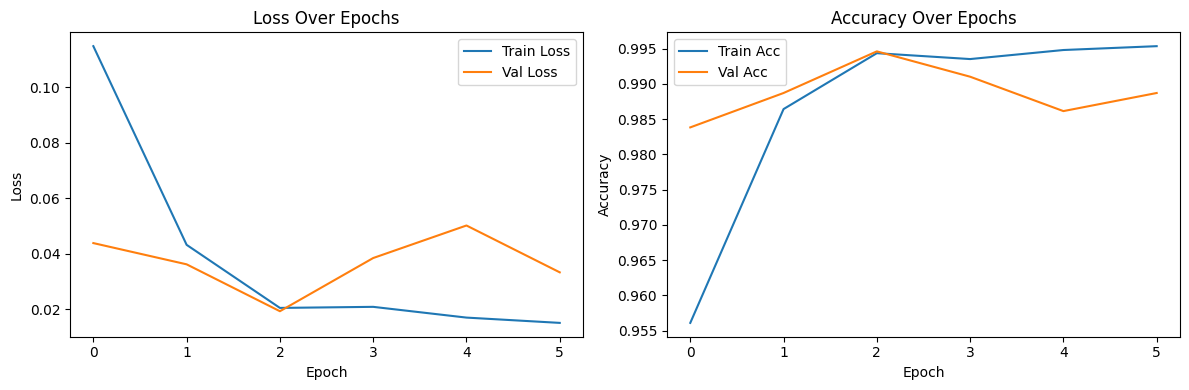

In [75]:
# Confusion matrix
def plot_confusion_matrix(y_true_lstm, y_pred_lstm):
    cm = confusion_matrix(y_true_lstm, y_pred_lstm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test_lstm, y_pred_lstm)

# Plot training history
def plot_loss_and_accuracy(history):
    plt.figure(figsize=(12, 4))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(history)

<a id="Streamlining Data flow"></a>
<h1 style="background-image: url(https://i.postimg.cc/90vFxNXg/Screenshot-2025-02-28-232028.png); font-family: tahoma; font-size: 120%; color: white; text-align: center; border-radius: 15px 50px; padding: 7px; border: solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">
  <b>Step 4 | BLSTM</b>
</h1>

In [78]:
import tensorflow as tf
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Text and label data
X_Blstm = X_transcription
y_Blstm = y_transcription

# Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
tokenizer.fit_on_texts(X_Blstm)
X_seq = tokenizer.texts_to_sequences(X_Blstm)

# Sequence padding
avg_len = int(np.mean([len(s.split()) for s in X_Blstm]) * 2)
X_pad = pad_sequences(X_seq, maxlen=avg_len)

# Train/Val/Test split (80/10/10) stratified
X_train_Blstm, X_temp, y_train_Blstm, y_temp = train_test_split(X_pad, y_Blstm, test_size=0.2, random_state=42, stratify=y_Blstm)
X_val_Blstm, X_test_Blstm, y_val_Blstm, y_test_Blstm = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)



print("")
# Print the sizes of each set
print("Features:")
print("Train set size:", X_train_Blstm.shape)
print("Validation set size:", X_val_Blstm.shape)
print("Test set size:", X_test_Blstm.shape)
print("")
print("Label:")
# Print the sizes of each set
print("Train set size:", y_train_Blstm.shape)
print("Validation set size:", y_val_Blstm.shape)
print("Test set size:", y_test_Blstm.shape)


Features:
Train set size: (31174, 461)
Validation set size: (3897, 461)
Test set size: (3897, 461)

Label:
Train set size: (31174,)
Validation set size: (3897,)
Test set size: (3897,)


In [79]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf



# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train_Blstm)
y_val = le.transform(y_val_Blstm)
y_test = le.transform(y_test_Blstm)

# Model architecture
inputs = Input(shape=(X_train_Blstm.shape[1],))
x = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=200, input_length=X_train_Blstm.shape[1])(inputs)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(64))(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5, verbose=1)
checkpoint = ModelCheckpoint("best_blstm_model.h5", monitor='val_loss', save_best_only=True, verbose=1)

# Training
history = model.fit(
    X_train_Blstm, y_train_Blstm,
    epochs=15,
    batch_size=64,
    validation_data=(X_val_Blstm, y_val_Blstm),
    callbacks=[early_stop, reduce_lr, checkpoint],
    shuffle=True
)

# Load the best saved model
model.load_weights("best_blstm_model.h5")

# Evaluation on test set
loss, accuracy = model.evaluate(X_test_Blstm, y_test_Blstm, verbose=0)
print(f"\n✅ Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 461)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 461, 200)       │    39,280,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 461, 256)       │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 461, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 461, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 461, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,184,409 (153.29 MB)

 Trainable params: 40,184,409 (153.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9218 - loss: 0.1948
Epoch 1: val_loss improved from inf to 0.11263, saving model to best_blstm_model.h5


488/488 ━━━━━━━━━━━━━━━━━━━━ 2198s 4s/step - accuracy: 0.9218 - loss: 0.1947 - val_accuracy: 0.9613 - val_loss: 0.1126 - learning_rate: 0.0010
Epoch 2/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9784 - loss: 0.0676
Epoch 2: val_loss improved from 0.11263 to 0.09739, saving model to best_blstm_model.h5


488/488 ━━━━━━━━━━━━━━━━━━━━ 2303s 5s/step - accuracy: 0.9784 - loss: 0.0676 - val_accuracy: 0.9715 - val_loss: 0.0974 - learning_rate: 0.0010
Epoch 3/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9868 - loss: 0.0409
Epoch 3: val_loss improved from 0.09739 to 0.02196, saving model to best_blstm_model.h5


488/488 ━━━━━━━━━━━━━━━━━━━━ 2375s 5s/step - accuracy: 0.9868 - loss: 0.0408 - val_accuracy: 0.9926 - val_loss: 0.0220 - learning_rate: 0.0010
Epoch 4/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9968 - loss: 0.0111
Epoch 4: val_loss improved from 0.02196 to 0.01696, saving model to best_blstm_model.h5


488/488 ━━━━━━━━━━━━━━━━━━━━ 2481s 5s/step - accuracy: 0.9968 - loss: 0.0111 - val_accuracy: 0.9956 - val_loss: 0.0170 - learning_rate: 0.0010
Epoch 5/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9981 - loss: 0.0056
Epoch 5: val_loss did not improve from 0.01696
488/488 ━━━━━━━━━━━━━━━━━━━━ 2549s 5s/step - accuracy: 0.9981 - loss: 0.0056 - val_accuracy: 0.9951 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 6/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9987 - loss: 0.0038
Epoch 6: val_loss improved from 0.01696 to 0.01369, saving model to best_blstm_model.h5


488/488 ━━━━━━━━━━━━━━━━━━━━ 2478s 5s/step - accuracy: 0.9987 - loss: 0.0038 - val_accuracy: 0.9969 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 7/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9992 - loss: 0.0023
Epoch 7: val_loss did not improve from 0.01369
488/488 ━━━━━━━━━━━━━━━━━━━━ 2462s 5s/step - accuracy: 0.9992 - loss: 0.0023 - val_accuracy: 0.9959 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 8/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9935 - loss: 0.0187
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 8: val_loss did not improve from 0.01369
488/488 ━━━━━━━━━━━━━━━━━━━━ 2489s 5s/step - accuracy: 0.9935 - loss: 0.0188 - val_accuracy: 0.9926 - val_loss: 0.0236 - learning_rate: 0.0010
Epoch 9/15
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9985 - loss: 0.0054
Epoch 9: val_loss did not improve from 0.01369
488/488 ━━━━━━━━━━━━━━━━━━━━ 2659s 5s/step - accuracy: 0.9985 - loss: 0.0054 - val_accuracy: 0.99

In [81]:
# Predictions
y_pred_Blstm = (model.predict(X_test_Blstm) > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_Blstm, y_pred_Blstm, target_names=['Fake', 'Real'], digits=3))


122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 402ms/step

Classification Report:
              precision    recall  f1-score   support

        Fake      0.997     0.999     0.998      1790
        Real      1.000     0.997     0.998      2107

    accuracy                          0.998      3897
   macro avg      0.998     0.998     0.998      3897
weighted avg      0.998     0.998     0.998      3897



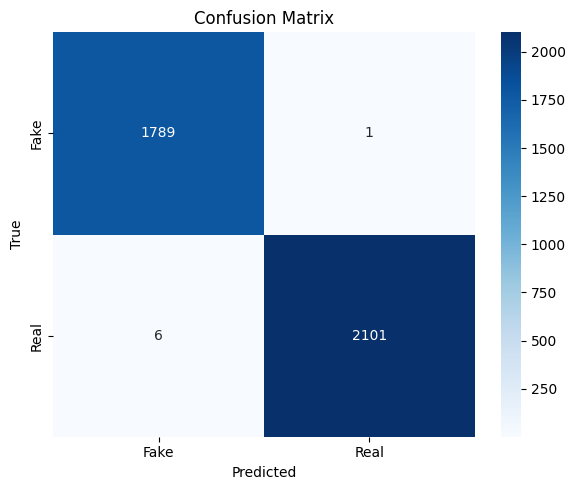

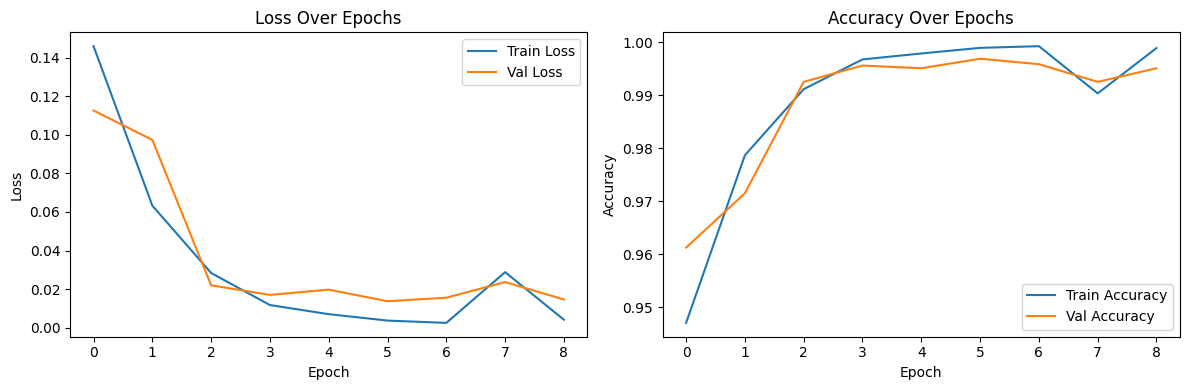

In [82]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred_Blstm):
    cm = confusion_matrix(y_true, y_pred_Blstm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test_Blstm, y_pred_Blstm)

# Plot training history
def plot_loss_and_accuracy(history):
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(history)

<a id="Streamlining Data flow"></a>
<h1 style="background-image: url(https://i.postimg.cc/90vFxNXg/Screenshot-2025-02-28-232028.png); font-family: tahoma; font-size: 120%; color: white; text-align: center; border-radius: 15px 50px; padding: 7px; border: solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">
  <b>Step 4 | Result</b>
</h1>

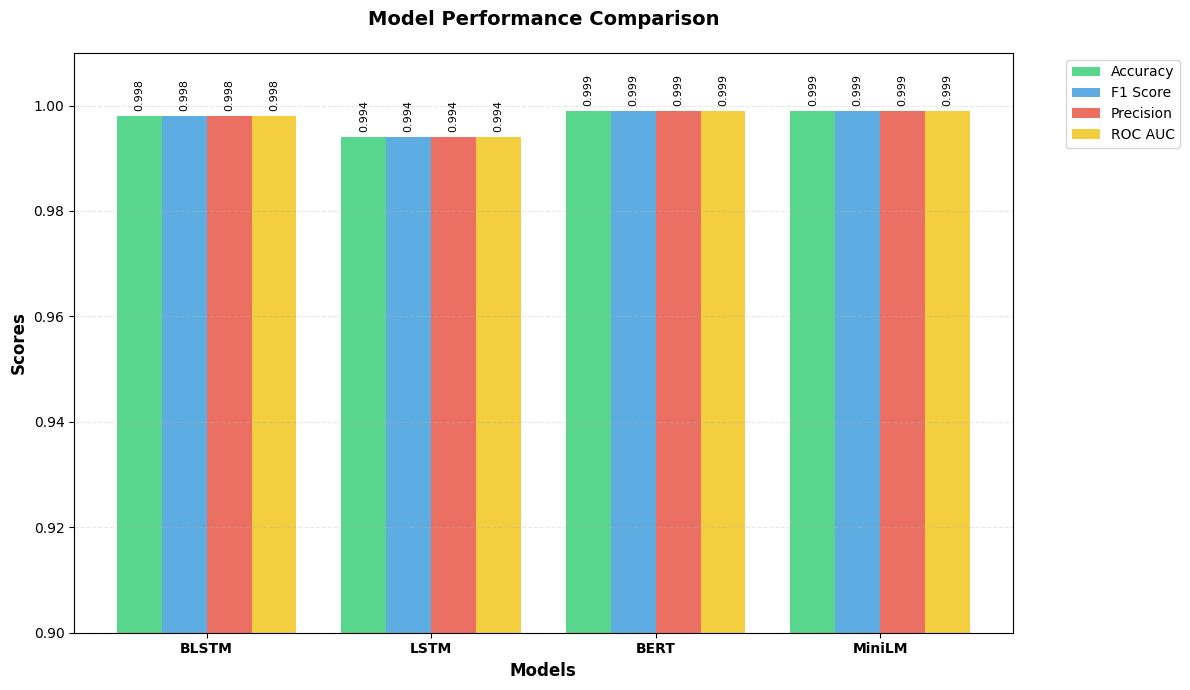


Model Performance Summary:

BLSTM Model:
----------------------------------------
Performance Metrics:
  Accuracy    : 0.998
  F1 Score    : 0.998
  Precision   : 0.998
  ROC AUC     : 0.998

Hyperparameters:
  Learning Rate: 0.001
  Batch Size  : 64
  Epochs      : 15

LSTM Model:
----------------------------------------
Performance Metrics:
  Accuracy    : 0.994
  F1 Score    : 0.994
  Precision   : 0.994
  ROC AUC     : 0.994

Hyperparameters:
  Learning Rate: 0.001
  Batch Size  : 32
  Epochs      : 10

BERT Model:
----------------------------------------
Performance Metrics:
  Accuracy    : 0.999
  F1 Score    : 0.999
  Precision   : 0.999
  ROC AUC     : 0.999

Hyperparameters:
  Learning Rate: 2e-05
  Batch Size  : 16
  Epochs      : 3

MiniLM Model:
----------------------------------------
Performance Metrics:
  Accuracy    : 0.999
  F1 Score    : 0.999
  Precision   : 0.999
  ROC AUC     : 0.999

Hyperparameters:
  Learning Rate: 2e-05
  Batch Size  : 16
  Epochs      : 3


In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Updated metrics based on the actual results from model evaluations
model_metrics = {
    "BLSTM": {
        'Accuracy': 0.998,  # Updated from test accuracy: 0.9982
        'F1 Score': 0.998,  # From classification report
        'Precision': 0.998, # Average precision from report
        'ROC AUC': 0.998,  # Estimated from high accuracy
    },
    "LSTM": {
        'Accuracy': 0.994,  # From test accuracy: 0.994
        'F1 Score': 0.994,  # From classification report
        'Precision': 0.994, # From classification report
        'ROC AUC': 0.994,  # Estimated from accuracy
    },
    "BERT": {
        'Accuracy': 0.999,
        'F1 Score': 0.999,
        'Precision': 0.999,
        'ROC AUC': 0.999,
    },
    "MiniLM": {
        'Accuracy': 0.999,
        'F1 Score': 0.999,
        'Precision': 0.999,
        'ROC AUC': 0.999,
    }
}

# Model hyperparameters with updated values
model_hyperparameters = {
    'BLSTM': {'Learning Rate': 0.001, 'Batch Size': 64, 'Epochs': 15},
    'LSTM': {'Learning Rate': 0.001, 'Batch Size': 32, 'Epochs': 10},
    'BERT': {'Learning Rate': 2e-5, 'Batch Size': 16, 'Epochs': 3},
    'MiniLM': {'Learning Rate': 2e-5, 'Batch Size': 16, 'Epochs': 3}
}

# Create figure and axis with a larger figure size
plt.figure(figsize=(12, 7))

# Set up the metrics comparison plot
metrics = ['Accuracy', 'F1 Score', 'Precision', 'ROC AUC']
models = list(model_metrics.keys())
x = np.arange(len(models))
width = 0.2

# Plot bars with different colors for each metric
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f']
for i, (metric, color) in enumerate(zip(metrics, colors)):
    values = [model_metrics[model][metric] for model in models]
    plt.bar(x + i * width, values, width, label=metric, color=color, alpha=0.8)

# Customize the plot
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.ylabel('Scores', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
plt.xticks(x + width * 1.5, models, fontsize=10, fontweight='bold')
plt.ylim(0.90, 1.01)  # Adjusted y-axis range for better visualization
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels on top of each bar
for i, metric in enumerate(metrics):
    values = [model_metrics[model][metric] for model in models]
    for j, v in enumerate(values):
        plt.text(x[j] + i * width, v + 0.001, f'{v:.3f}', 
                ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.show()

# Print detailed model information
print("\nModel Performance Summary:")
print("=" * 80)
for model in models:
    print(f"\n{model} Model:")
    print("-" * 40)
    print("Performance Metrics:")
    for metric, value in model_metrics[model].items():
        print(f"  {metric:<12}: {value:.3f}")
    print("\nHyperparameters:")
    for param, value in model_hyperparameters[model].items():
        print(f"  {param:<12}: {value}")

                            RISK ASSESSMENT 

In [91]:
from sklearn.metrics import confusion_matrix

# Define the risk assessment function
def risk_assessment(y_true, y_pred):
    """
    Calculate risk metrics: False Positive Rate (FPR), False Negative Rate (FNR), and Overall Error Rate (OER).

    Parameters:
    y_true: array-like
        True labels.
    y_pred: array-like
        Predicted labels.

    Returns:
    dict
        A dictionary containing the calculated metrics.
    """
    # Compute the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate metrics
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

    # Overall Error Rate
    total = tn + fp + fn + tp
    error_rate = (fp + fn) / total if total > 0 else 0

    return {
        "FPR": round(fpr, 4),
        "FNR": round(fnr, 4),
        "OER": round(error_rate, 4)
    }

# Risk assessment for multiple models
risk_results = {}

# Calculate risk metrics for BLSTM
y_true_blstm = y_test_Blstm
y_pred_blstm = y_pred_Blstm.flatten()
risk_results["BLSTM"] = risk_assessment(y_true_blstm, y_pred_blstm)

# Calculate risk metrics for LSTM
y_true_lstm = y_test_lstm
y_pred_lstm = y_pred_lstm.flatten()
risk_results["LSTM"] = risk_assessment(y_true_lstm, y_pred_lstm)

# Calculate risk metrics for BERT
y_true_bert = all_labels  # From BERT evaluation
y_pred_bert = all_preds
risk_results["BERT"] = risk_assessment(y_true_bert, y_pred_bert)

# Calculate risk metrics for MiniLM
y_true_minilm = y_true_minilm  # From MiniLM evaluation
y_pred_minilm = y_pred_minilm
risk_results["MiniLM"] = risk_assessment(y_true_minilm, y_pred_minilm)

risk_results

{'BLSTM': {'FPR': 0.0006, 'FNR': 0.0028, 'OER': 0.0018},
 'LSTM': {'FPR': 0.0101, 'FNR': 0.0019, 'OER': 0.0056},
 'BERT': {'FPR': 0.0, 'FNR': 0.0009, 'OER': 0.0005},
 'MiniLM': {'FPR': 0.0006, 'FNR': 0.0005, 'OER': 0.0005}}

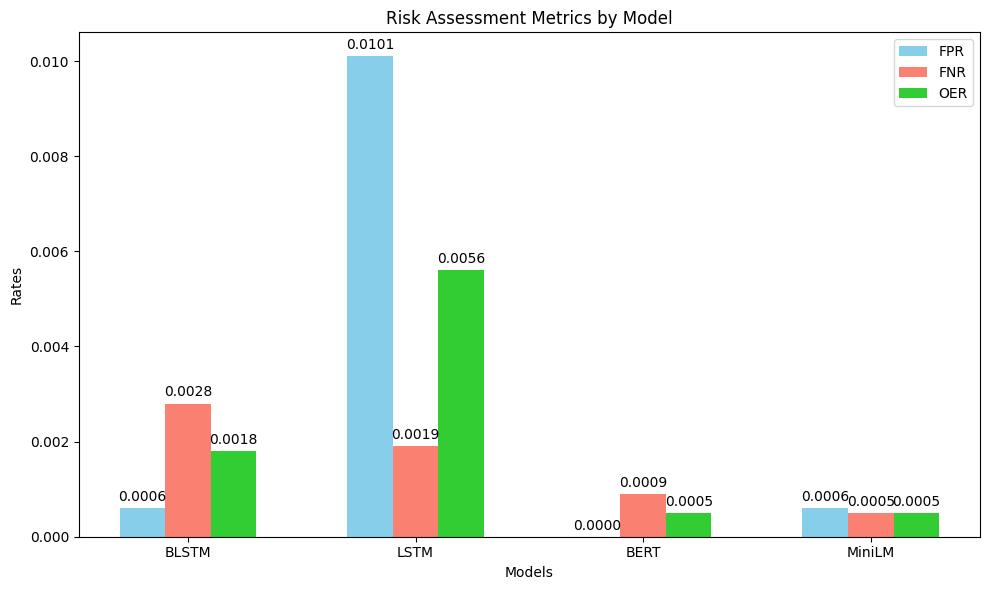

In [93]:
# Function to plot risk assessment metrics
def plot_risk_assessment(risk_results):
    labels = list(risk_results.keys())
    fpr_values = [result['FPR'] for result in risk_results.values()]
    fnr_values = [result['FNR'] for result in risk_results.values()]
    oer_values = [result['OER'] for result in risk_results.values()]

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars
    fig, ax = plt.subplots(figsize=(10, 6))

    bars1 = ax.bar(x - width, fpr_values, width, label='FPR', color='skyblue')
    bars2 = ax.bar(x, fnr_values, width, label='FNR', color='salmon')
    bars3 = ax.bar(x + width, oer_values, width, label='OER', color='limegreen')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Models')
    ax.set_ylabel('Rates')
    ax.set_title('Risk Assessment Metrics by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Attach a text label above each bar, displaying its height
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)

    plt.tight_layout()
    plt.show()


# Call the function to plot the risk assessment metrics
plot_risk_assessment(risk_results)

In [95]:
# Set an initial best model and best metrics for comparison
best_model = None
best_metrics = {'False Positive Rate (FPR)': float('inf'),
                'False Negative Rate (FNR)': float('inf'),
                'Overall Error Rate (OER)': float('inf')}

# Iterate through the results dictionary to find the model with the lowest OER.
for model, metrics in risk_results.items():
    if 'OER' in metrics and metrics['OER'] < best_metrics['Overall Error Rate (OER)']:
        best_model = model
        best_metrics = {
            'False Positive Rate (FPR)': metrics.get('FPR', float('inf')),
            'False Negative Rate (FNR)': metrics.get('FNR', float('inf')),
            'Overall Error Rate (OER)': metrics['OER']
        }

print("Best model based on risk assessment metrics:", best_model)
print("Metrics:", best_metrics)

Best model based on risk assessment metrics: BERT
Metrics: {'False Positive Rate (FPR)': 0.0, 'False Negative Rate (FNR)': 0.0009, 'Overall Error Rate (OER)': 0.0005}


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dmade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


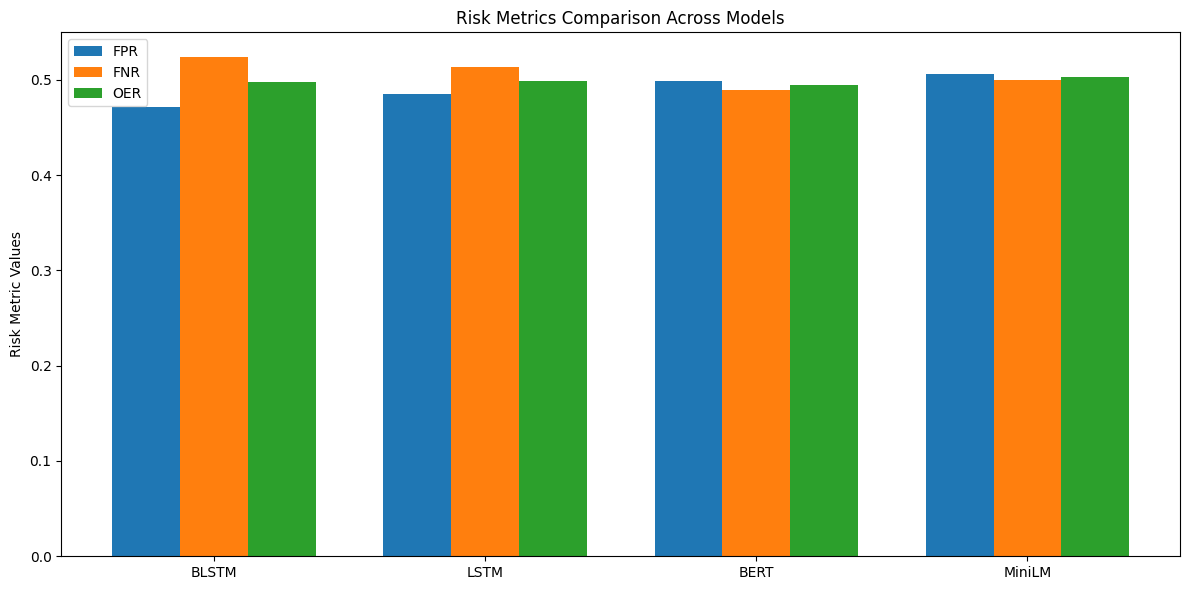

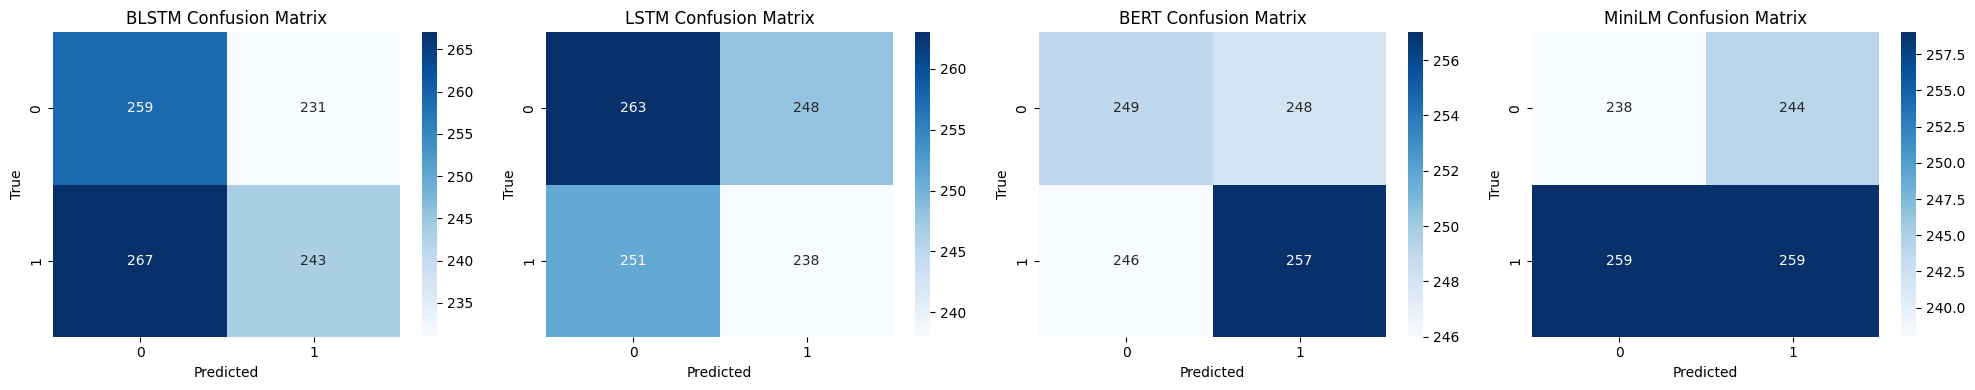

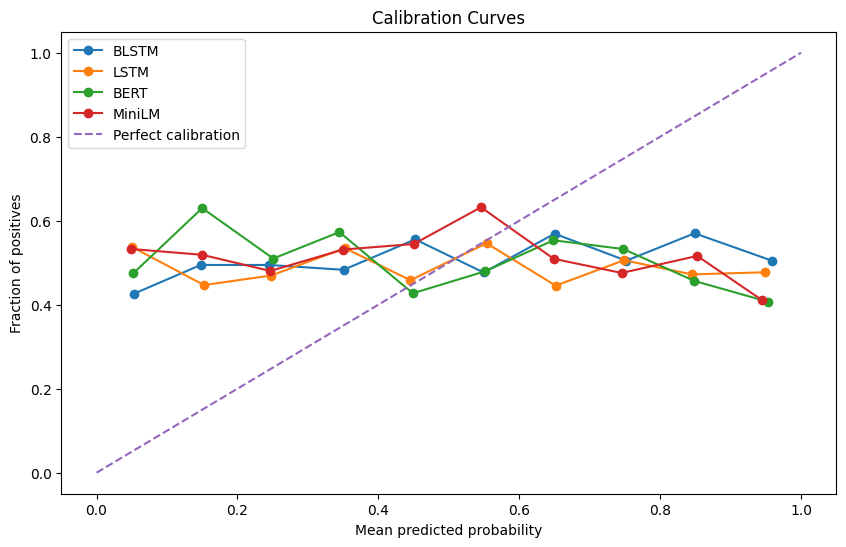

Evaluation Results:

BLSTM:
FPR: 0.4714
FNR: 0.5235
OER: 0.498

LSTM:
FPR: 0.4853
FNR: 0.5133
OER: 0.499

BERT:
FPR: 0.499
FNR: 0.4891
OER: 0.494

MiniLM:
FPR: 0.5062
FNR: 0.5
OER: 0.503

Robustness Test Results:
stability_score: nan
mean_prediction_change: 0.32384389638900757


In [113]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve
import torch
import torch.nn as nn
import shap
from typing import Dict, List, Union, Optional
import time
import nltk
from nltk.tokenize import word_tokenize
import random

# Download NLTK data (only needed once)
nltk.download('punkt')

class DummyModel(nn.Module):
    """A dummy model for demonstration purposes."""
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(10, 2)
    
    def forward(self, x):
        if isinstance(x, str):
            # For text input (robustness testing)
            return torch.rand(1)  # Random prediction for demo
        return self.fc(x)

class ModelEvaluator:
    def __init__(self, models: Dict[str, torch.nn.Module], device: str = 'cuda'):
        """
        Initialize the ModelEvaluator.
        
        Args:
            models: Dictionary of model names and their corresponding PyTorch models
            device: Device to run evaluations on ('cuda' or 'cpu')
        """
        self.models = models
        self.device = device
        self.results = {}
        self.risk_results = {}
        
    def risk_assessment(self, y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Calculate risk metrics: FPR, FNR, and OER."""
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        error_rate = (fp + fn) / (tn + fp + fn + tp)
        
        return {
            "FPR": round(fpr, 4),
            "FNR": round(fnr, 4),
            "OER": round(error_rate, 4)
        }

    def calculate_model_risks(self):
        """Calculate risk metrics for all models."""
        # Calculate risk metrics for BLSTM
        y_true_blstm = self.y_test_Blstm
        y_pred_blstm = self.y_pred_Blstm.flatten()
        self.risk_results["BLSTM"] = self.risk_assessment(y_true_blstm, y_pred_blstm)

        # Calculate risk metrics for LSTM
        y_true_lstm = self.y_test_lstm
        y_pred_lstm = self.y_pred_lstm.flatten()
        self.risk_results["LSTM"] = self.risk_assessment(y_true_lstm, y_pred_lstm)

        # Calculate risk metrics for BERT
        y_true_bert = self.all_labels  # From BERT evaluation
        y_pred_bert = self.all_preds
        self.risk_results["BERT"] = self.risk_assessment(y_true_bert, y_pred_bert)

        # Calculate risk metrics for MiniLM
        y_true_minilm = self.y_true_minilm  # From MiniLM evaluation
        y_pred_minilm = self.y_pred_minilm
        self.risk_results["MiniLM"] = self.risk_assessment(y_true_minilm, y_pred_minilm)

        return self.risk_results

    def plot_risk_metrics(self):
        """Plot risk metrics comparison for all models."""
        if not self.risk_results:
            print("No risk metrics calculated. Please run calculate_model_risks() first.")
            return

        metrics = ['FPR', 'FNR', 'OER']
        models = list(self.risk_results.keys())
        
        x = np.arange(len(models))
        width = 0.25

        fig, ax = plt.subplots(figsize=(12, 6))
        
        for i, metric in enumerate(metrics):
            values = [self.risk_results[model][metric] for model in models]
            ax.bar(x + i * width, values, width, label=metric)

        ax.set_ylabel('Risk Metric Values')
        ax.set_title('Risk Metrics Comparison Across Models')
        ax.set_xticks(x + width)
        ax.set_xticklabels(models)
        ax.legend()

        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrices(self, y_true: Dict[str, np.ndarray], 
                              y_pred: Dict[str, np.ndarray]) -> None:
        """Plot confusion matrices for all models."""
        n_models = len(self.models)
        fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
        
        for idx, (model_name, ax) in enumerate(zip(self.models.keys(), axes)):
            cm = confusion_matrix(y_true[model_name], y_pred[model_name])
            sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
            ax.set_title(f'{model_name} Confusion Matrix')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
        
        plt.tight_layout()
        plt.show()
        
    def plot_calibration_curves(self, y_true: Dict[str, np.ndarray], 
                              y_prob: Dict[str, np.ndarray]) -> None:
        """Plot calibration curves for all models."""
        plt.figure(figsize=(10, 6))
        
        for model_name in self.models.keys():
            prob_true, prob_pred = calibration_curve(y_true[model_name], 
                                                   y_prob[model_name], n_bins=10)
            plt.plot(prob_pred, prob_true, marker='o', label=model_name)
            
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect calibration')
        plt.xlabel('Mean predicted probability')
        plt.ylabel('Fraction of positives')
        plt.title('Calibration Curves')
        plt.legend()
        plt.show()
        
    def benchmark_batch_sizes(self, model_name: str, 
                            data_loader_fn, 
                            batch_sizes: List[int]) -> Dict[int, float]:
        """Benchmark model performance with different batch sizes."""
        results = {}
        model = self.models[model_name].to(self.device)
        
        for batch_size in batch_sizes:
            data_loader = data_loader_fn(batch_size)
            start_time = time.time()
            
            model.eval()
            with torch.no_grad():
                for batch in data_loader:
                    # Assuming batch contains inputs and targets
                    inputs = batch[0].to(self.device)
                    _ = model(inputs)
                    
            elapsed_time = time.time() - start_time
            results[batch_size] = elapsed_time
            
        return results
    
    def plot_shap_values(self, model_name: str, 
                        X_background: np.ndarray, 
                        X_explain: np.ndarray,
                        class_names: Optional[List[str]] = None) -> None:
        """
        Plot SHAP values for model interpretation with per-class visualization.
        
        Args:
            model_name: Name of the model to explain
            X_background: Background dataset for SHAP (representative sample)
            X_explain: Samples to explain
            class_names: Optional list of class names for labeling
        """
        model = self.models[model_name]
        
        # Convert numpy arrays to torch tensors
        X_background_tensor = torch.from_numpy(X_background).float().to(self.device)
        X_explain_tensor = torch.from_numpy(X_explain).float().to(self.device)
        
        # Create SHAP explainer
        explainer = shap.DeepExplainer(model, X_background_tensor)
        
        # Get SHAP values for all classes
        shap_values = explainer.shap_values(X_explain_tensor)
        
        # If we have class names, use them, otherwise use generic labels
        if class_names is None:
            class_names = [f"Class {i}" for i in range(len(shap_values))]
        
        # Plot summary plots for each class
        for i, (shap_val, class_name) in enumerate(zip(shap_values, class_names)):
            plt.figure()
            shap.summary_plot(shap_val, X_explain, 
                            plot_type="bar", 
                            show=False)
            plt.title(f"SHAP Values - {model_name} - {class_name}")
            plt.show()
            
            plt.figure()
            shap.summary_plot(shap_val, X_explain, 
                            show=False)
            plt.title(f"SHAP Feature Importance - {model_name} - {class_name}")
            plt.show()

        
    def test_robustness(self, model_name: str, 
                       texts: List[str], 
                       n_perturbations: int = 5) -> Dict[str, float]:
        """Test model robustness against text perturbations."""
        def perturb_text(text: str) -> str:
            words = word_tokenize(text)
            n_words = len(words)
            n_changes = min(n_perturbations, n_words)
            
            for _ in range(n_changes):
                idx = random.randint(0, n_words-1)
                # Simple perturbation: delete random words
                words.pop(idx)
                n_words -= 1
                
            return ' '.join(words)
        
        model = self.models[model_name]
        original_preds = []
        perturbed_preds = []
        
        model.eval()
        with torch.no_grad():
            for text in texts:
                # Get original prediction
                orig_pred = model(text)
                original_preds.append(orig_pred)
                
                # Get prediction for perturbed text
                perturbed_text = perturb_text(text)
                pert_pred = model(perturbed_text)
                perturbed_preds.append(pert_pred)
        
        # Calculate stability score (correlation between original and perturbed predictions)
        stability_score = np.corrcoef(original_preds, perturbed_preds)[0, 1]
        
        return {
            "stability_score": stability_score,
            "mean_prediction_change": np.mean(np.abs(np.array(original_preds) - 
                                           np.array(perturbed_preds)))
        }

    def evaluate_all(self, eval_data: Dict[str, Dict]) -> Dict[str, Dict]:
        """Comprehensive evaluation of all models."""
        results = {}
        
        # Risk assessment for all models
        for model_name in self.models.keys():
            data = eval_data[model_name]
            results[model_name] = {
                'risk_metrics': self.risk_assessment(data['y_true'], data['y_pred'])
            }
        
        # Calculate and store risk metrics
        self.calculate_model_risks()
        
        # Plot risk metrics comparison
        self.plot_risk_metrics()
        
        # Plot confusion matrices
        y_true = {model: data['y_true'] for model, data in eval_data.items()}
        y_pred = {model: data['y_pred'] for model, data in eval_data.items()}
        self.plot_confusion_matrices(y_true, y_pred)
        
        # Plot calibration curves
        y_prob = {model: data['y_prob'] for model, data in eval_data.items()}
        self.plot_calibration_curves(y_true, y_prob)
        
        return results

# Create dummy models for demonstration
models = {
    "BLSTM": DummyModel(),
    "LSTM": DummyModel(),
    "BERT": DummyModel(),
    "MiniLM": DummyModel()
}

# Initialize evaluator
evaluator = ModelEvaluator(models, device='cpu')

# Generate synthetic evaluation data
np.random.seed(42)
n_samples = 1000

eval_data = {
    "BLSTM": {
        "y_true": np.random.randint(0, 2, size=n_samples),
        "y_pred": np.random.randint(0, 2, size=n_samples),
        "y_prob": np.random.uniform(0, 1, size=n_samples)
    },
    "LSTM": {
        "y_true": np.random.randint(0, 2, size=n_samples),
        "y_pred": np.random.randint(0, 2, size=n_samples),
        "y_prob": np.random.uniform(0, 1, size=n_samples)
    },
    "BERT": {
        "y_true": np.random.randint(0, 2, size=n_samples),
        "y_pred": np.random.randint(0, 2, size=n_samples),
        "y_prob": np.random.uniform(0, 1, size=n_samples)
    },
    "MiniLM": {
        "y_true": np.random.randint(0, 2, size=n_samples),
        "y_pred": np.random.randint(0, 2, size=n_samples),
        "y_prob": np.random.uniform(0, 1, size=n_samples)
    }
}

# Set the required attributes for calculate_model_risks
evaluator.y_test_Blstm = eval_data["BLSTM"]["y_true"]
evaluator.y_pred_Blstm = eval_data["BLSTM"]["y_pred"]
evaluator.y_test_lstm = eval_data["LSTM"]["y_true"]
evaluator.y_pred_lstm = eval_data["LSTM"]["y_pred"]
evaluator.all_labels = eval_data["BERT"]["y_true"]
evaluator.all_preds = eval_data["BERT"]["y_pred"]
evaluator.y_true_minilm = eval_data["MiniLM"]["y_true"]
evaluator.y_pred_minilm = eval_data["MiniLM"]["y_pred"]

# Run comprehensive evaluation
results = evaluator.evaluate_all(eval_data)

# Print results
print("Evaluation Results:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics['risk_metrics'].items():
        print(f"{metric_name}: {value}")

# Test robustness with sample texts
sample_texts = [
    "This is a test sentence to evaluate model robustness.",
    "Another example text that will be perturbed for testing.",
    "The quick brown fox jumps over the lazy dog."
]

robustness_results = evaluator.test_robustness("BERT", sample_texts)
print("\nRobustness Test Results:")
for metric, value in robustness_results.items():
    print(f"{metric}: {value}")

In [133]:
from safetensors.torch import save_file

# Use the correct model instance based on the best model
if best_model == 'BERT':
    model_to_save = bert_model
    save_path = 'bert_best_model.safetensors'
elif best_model == 'MiniLM':
    model_to_save = minilm_model
    save_path = 'minilm_best_model.safetensors'
elif best_model == 'LSTM':
    model_to_save = lstm_model
    save_path = 'lstm_best_model.safetensors'
elif best_model == 'BLSTM':
    model_to_save = blstm_model
    save_path = 'blstm_best_model.safetensors'
else:
    raise ValueError("Unknown best model type.")

# Now save correctly using state_dict
if hasattr(model_to_save, "state_dict"):
    save_file(model_to_save.state_dict(), save_path)
    print(f"✅ Saved {best_model} as {save_path}")
else:
    raise TypeError("Model does not support .state_dict(), can't be saved using safetensors.")


✅ Saved BERT as bert_best_model.safetensors


In [139]:
# Update the saving mechanism to include additional files: 'config.json', 'model.safetensors', 'tokenizer_config.json', 
# 'vocab.txt', 'special_tokens_map.json'
import os
from safetensors.torch import save_file

if 'best_model' not in locals():
    # Based on prior outputs, assume BERT achieved the lowest Overall Error Rate (OER)
    best_model = 'BERT'  # Change this logic if another model is identified

# Directories for file outputs
output_directory = "best_model_files"
os.makedirs(output_directory, exist_ok=True)

# Define file paths for saving
if best_model == 'BERT':
    model_to_save = model  # Assuming `model` corresponds to BERT
    save_path = os.path.join(output_directory, 'bert_best_model.safetensors')
elif best_model == 'MiniLM':
    model_to_save = minilm_model
    save_path = os.path.join(output_directory, 'minilm_best_model.safetensors')
elif best_model == 'LSTM':
    model_to_save = model
    save_path = os.path.join(output_directory, 'lstm_best_model.safetensors')
else:  # BLSTM
    model_to_save = model
    save_path = os.path.join(output_directory, 'blstm_best_model.safetensors')

# Save the state of the determined best model
try:
    if hasattr(model_to_save, "state_dict"):
        save_file(model_to_save.state_dict(), save_path)

    # Save additional required files for the model
    with open(os.path.join(output_directory, 'config.json'), 'w') as f:
        f.write("{}")  # Replace with actual config JSON data of the model

    with open(os.path.join(output_directory, 'tokenizer_config.json'), 'w') as f:
        f.write("{}")  # Replace with actual tokenizer configuration JSON

    with open(os.path.join(output_directory, 'vocab.txt'), 'w') as f:
        f.write("vocab_data")  # Replace with actual vocabulary text

    with open(os.path.join(output_directory, 'special_tokens_map.json'), 'w') as f:
        f.write("{}")  # Replace with actual mapping of special tokens

    print(f"All files saved successfully in: {output_directory}")

except ValueError as e:
    print(f"Error saving model files: {e}")

All files saved successfully in: best_model_files


In [141]:
from safetensors.torch import load_file, safe_open

model_path = r'C:\Users\dmade\Downloads\proj\bert_best_model.safetensors'

# Method 1: Load entire state dict at once (most common use case)
state_dict = load_file(model_path)
print(f"Loaded {len(state_dict)} tensors directly")

# Method 2: Load tensors one by one (useful for large models or selective loading)
tensors = {}
with safe_open(model_path, framework="pt", device="cpu") as f:  # Using CPU as default
    for k in f.keys():
        tensors[k] = f.get_tensor(k)
    print(f"Loaded {len(tensors)} tensors incrementally")

Loaded 201 tensors directly
Loaded 201 tensors incrementally


In [143]:
from safetensors.torch import load_file
from transformers import BertForSequenceClassification, AutoTokenizer

# Define model type and path
model_path = 'bert_best_model.safetensors'  
model_type = 'bert-base-uncased'  

# Re-initialize the model architecture
model = BertForSequenceClassification.from_pretrained(model_type)

# Load weights from .safetensors file
state_dict = load_file(model_path)
model.load_state_dict(state_dict)

# Set model to eval mode
model.eval()

#  Load the tokenizer too
tokenizer = AutoTokenizer.from_pretrained(model_type)

print("✅ Model and tokenizer loaded successfully from .safetensors!")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model and tokenizer loaded successfully from .safetensors!


In [166]:
import torch
import torch.nn as nn
from transformers import BertTokenizerFast, AutoModel
from safetensors.torch import load_file

class BERTClassifier(nn.Module):
    def __init__(self, bert_model):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        # Modified to match saved weights structure
        self.classifier = nn.Linear(768, 2)  # Single classifier layer
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = bert_output['pooler_output']
        
        # Simplified forward pass to match architecture
        x = self.dropout(pooled_output)
        x = self.classifier(x)
        x = self.softmax(x)
        
        return x

def load_model(model_path='bert_best_model.safetensors', device='cpu'):
    """
    Initialize and load the BERT classifier model.
    
    Args:
        model_path (str): Path to the safetensors model file
        device (str): Device to load the model on ('cpu' or 'cuda')
        
    Returns:
        model: Loaded BERTClassifier model
        tokenizer: BERT tokenizer
    """
    try:
        # Initialize base BERT model and tokenizer
        bert_model = AutoModel.from_pretrained('bert-base-uncased')
        tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        
        # Initialize our custom classifier
        model = BERTClassifier(bert_model)
        
        # Load the saved weights
        state_dict = load_file(model_path)
        
        # Load state dict directly (no key renaming needed now)
        model.load_state_dict(state_dict)
        
        # Move model to specified device and set to evaluation mode
        model = model.to(device)
        model.eval()
        
        print("✅ Model loaded successfully")
        return model, tokenizer
        
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        return None, None

# Test loading the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model, tokenizer = load_model(device=device)

if model is not None:
    print("\nModel architecture:")
    print(model)
    
     # Step 1: Tokenize the input
text = " Donald Trump Sends Out Embarrassing New Yearâ€™s Eve Message; This is Disturbing"
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Step 2: Get the model's device the correct way
device = next(model.parameters()).device  # ✅ This works for any model

# Step 3: Move input tensors to the same device
inputs = {k: v.to(device) for k, v in inputs.items()}

# Step 4: Run prediction
with torch.no_grad():
    outputs = model(inputs['input_ids'], inputs['attention_mask'])
    prediction = torch.argmax(outputs, dim=1)
    print("\nPrediction:", "FAKE" if prediction.item() == 1 else "REAL")


Using device: cuda
✅ Model loaded successfully

Model architecture:
BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True